# Node2Vec

In this notebook we look at how to deploy the `Node2Vec` algorithm. We refer to [this](https://github.com/thibaudmartinez/node2vec) implementation which is particularly efficient, but other solutions are also available.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from node2vec.model import Node2Vec
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from src.CD import *

## Community detection

As we did for spectral clustering, we can use `Node2Vec` to generate the embeddings and then use a clustering algorithm (such as `k-means`) to perform community detection. Let us check how. As an exercise, check how the algorithm performance varies by changing the parameters ($\Gamma, k, n, d$).

In [6]:
'''Generate the graph'''

k = 3                                   # number of communities
n = 5000                                # number of nodes
Γ = 4                                   # ratio c_in/c_out (the larger is alpha, the simpler the problem)
c = 9                                   # expected average degree
c_in, c_out = 2*c*Γ/(1+Γ), 2*c/(1+Γ)    # connections parameters
C = np.ones((k,k))*c_out + np.diag(np.ones(k))*(c_in - c_out) 
c = (c_in + (k-1)*c_out)/k 

θ = np.random.uniform(3,12,n)**6        # get a non uniform degree distribution
θ = θ/np.mean(θ)
φ = np.mean(θ**2)

π_v = np.array([1/k for a in range(k)]) # set the sizes of each class
Π_v = (np.cumsum([x for x in π_v]))*n

label_gt, a = np.zeros(n), 0            # create the label vector
for i in range(n):
    if i > Π_v[a]:
        a = a+1
        
    label_gt[i] = a

label_gt = label_gt.astype(int)         
A, label_gt = DCSBM(C,c, label_gt, θ)   # generate the matrix
d = A@np.ones(n)                        # consider only the non-isolated nodes
idx = d > 0
A = A[idx][:,idx]
n, _ = A.shape
label_gt = label_gt[idx]

φ = np.mean(θ**2)
α = (c - c_out)*np.sqrt(φ/c)
print(f'α = {α}')

α = 2.265552056824437


In [7]:
# run Node2Vec
dim = 30  
src_nodes, dest_nodes = A.nonzero()
node2vec_model = Node2Vec(src_nodes, dest_nodes, graph_is_directed = False)
node2vec_model.simulate_walks(walk_length = 15, p = 1, q = 1)
node2vec_model.learn_embeddings(dimensions = dim, workers = 8)
X = node2vec_model.embeddings

# perform kmeans
label = KMeans(n_clusters = k).fit(X).labels_
print(f'AMI Node2Vec: {ami(label, label_gt)}')

Preprocessing progress: 96.01%%4.01%ing progress: 0Preprocessing progress: 
Preprocessing transition probabilities: done!
Walking progress: 90.01%ing progress: 0%0Walking progress: %0%
Simulating random walks: done!
Learning embeddings using the Skip-Gram model...
Learning embeddings: done!
AMI Node2Vec: 0.35515739266801066


The matrix $XX^T \in \mathbb{R}^{n\times n}$ can be seen as a proxy of the adjacency matrix. Its rank is certainly smaller or equal to $d$ (by construction), but in the presence of a community structure, we expect that it has exactly $k$ eigenvalues that are far apart from the others. Luckily, the non zero eigenvalues of $XX^T$ are also non zero eigenvalues of $X^TX\in\mathbb{R}^{d\times d}$ that can be efficiently computed in $\mathcal{O}(nd + d^3)$ operations. We can thus use this method to also estimate the number of communities.

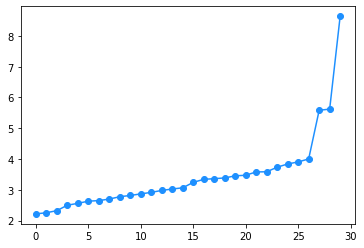

In [8]:
γ = np.linalg.eigvalsh(X.T@X)

plt.plot(np.log(γ), marker = 'o', color = 'dodgerblue')
plt.show();

## Link prediction

One of the many possible tasks that can be performed once the embedding is given is *link prediction* that consists in trying to individuate what are the most likely links that may be present in a partially observed network. The quantity $\mathbf{x}_i^T\mathbf{x}_j$, in fact, can be computed also for pairs $(ij)\notin\mathcal{E}$. When it takes a large value, it means that, even if $i$ and $j$ are not connected, they have a large structural similarity.

In the following example we consider a graph in which we only observe 85% of the edges. We use this graph to learn the embedding of the nodes and then use it to guess what are the most likely missing edges.

In [9]:
# load the dataset
df = pd.read_csv('Data/PubMed/PubMed.edges', header = None, names = ['i', 'j'])

# map the nodes indices to values between 0 and n
all_nodes = np.unique(df.values)
n = len(all_nodes)
Mapper = dict(zip(all_nodes, np.arange(n)))
df.i = df.i.map(lambda x: Mapper[x])
df.j = df.j.map(lambda x: Mapper[x])

# create a mask, so that only 85% of the data are observed. df_train contains the observed
# edges, while df_test the unobserved ones
mask = np.random.binomial(1, 0.85, len(df)) == 1
df_train = df[mask]
df_test = df[~mask]

# build the adjacency matrix based on the observed edges
A = csr_matrix((np.ones(len(df_train)), (df_train.i, df_train.j)), shape = (n,n))
A = (A + A.T).sign()

# generate the embedding (adding self loops for convenience)
dim = 30
Id = diags(np.ones(n))
src_nodes, dest_nodes = (A+Id).nonzero()
node2vec_model = Node2Vec(src_nodes, dest_nodes, graph_is_directed = False)
node2vec_model.simulate_walks(walk_length = 15, p = 1., q = 1.0)
node2vec_model.learn_embeddings(dimensions = dim, workers = 8)
X = node2vec_model.embeddings

Learning embeddings using the Skip-Gram model...
Preprocessing progress: 97.89%cessing progress: 89.26%86.73%8.91%
Preprocessing transition probabilities: done!
Walking progress: 91.29%0%progress: 0
Simulating random walks: done!
Learning embeddings: done!


We have a set of indices pairs corresponding to existing but unobserved edges. We now create another one by selecting random pairs of indices and compare the distribution of $\mathbf{x}_i^T\mathbf{x}_j$ in the two cases. The plot shows that the scalar product has significantly larger values for pairs of nodes corresponding to missing edges, thus showing the possibility of performing link prediction with this embedding-based method.

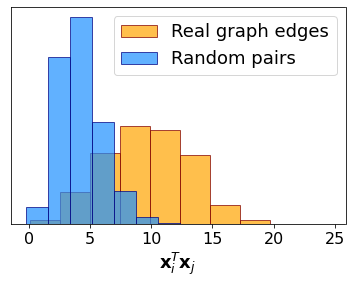

In [10]:
indeces = np.random.choice(np.arange(n), (len(df_test),2))

SimTrue = np.sum(X[df_test.i]*X[df_test.j], axis = 1)
SimRdn = np.sum(X[indeces[:,0]]*X[indeces[:,1]], axis = 1)

plt.hist(SimTrue, density = True, color = 'orange', edgecolor = 'maroon', alpha = .7, label = 'Real graph edges')
plt.hist(SimRdn, density = True, color = 'dodgerblue', edgecolor = 'navy', alpha = .7, label = 'Random pairs')
plt.xlabel(r'$\mathbf{x}_i^T\mathbf{x}_j$', fontsize = 18)
plt.legend(fontsize =  18)
plt.yticks([])
plt.xticks(fontsize = 16)
plt.show();